download data from here : [https://download.pytorch.org/tutorial/hymenoptera_data.zip](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

### Point to remember
- scheduler
```python
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# call step every epoch to change lr
scheduler.step() 
```
- don't update grad
```python
with torch.set_grad_enabled(phase == 'train'):
    ....
```
- get all weights
```python
model.state_dict()
```

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### 1. load data

In [61]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

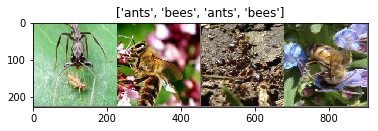

In [62]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # if no clip it will show warning
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Train
- Scheduling the learning rate
- Saving the best model

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()                                                 # ?????
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                   # ?????
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [35]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/epinyoanun/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:06<00:00, 6727066.42it/s]


In [37]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7412 Acc: 0.7049
val Loss: 0.1526 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.7219 Acc: 0.7336
val Loss: 0.3628 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4956 Acc: 0.8074
val Loss: 0.4328 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.4748 Acc: 0.8156
val Loss: 0.2351 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3957 Acc: 0.8279
val Loss: 0.3101 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3738 Acc: 0.8320
val Loss: 0.3992 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5763 Acc: 0.7787
val Loss: 1.5673 Acc: 0.5359

Epoch 7/24
----------
train Loss: 0.5610 Acc: 0.7582
val Loss: 0.3012 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3465 Acc: 0.8607
val Loss: 0.2499 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3459 Acc: 0.8730
val Loss: 0.2340 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2728 Acc: 0.8811
val Loss: 0.2369 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3763 Acc: 0.8443
val Loss: 0.2198 Acc: 0.9216

Ep

### 3. Freeze all layers, exept the last one [Alternative]

In [58]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [59]:
model_conv = train_model(model_conv, 
                         criterion, 
                         optimizer_conv,
                         exp_lr_scheduler, 
                         num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5962 Acc: 0.6926
val Loss: 0.3260 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5248 Acc: 0.7951
val Loss: 0.2195 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4301 Acc: 0.8033
val Loss: 0.1860 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4710 Acc: 0.8197
val Loss: 0.2026 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4879 Acc: 0.8074
val Loss: 0.2225 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5667 Acc: 0.7787
val Loss: 0.2305 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3976 Acc: 0.8074
val Loss: 0.2498 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3727 Acc: 0.8443
val Loss: 0.1754 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3945 Acc: 0.8156
val Loss: 0.1919 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3426 Acc: 0.8648
val Loss: 0.1910 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3146 Acc: 0.8402
val Loss: 0.2176 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3538 Acc: 0.8361
val Loss: 0.2083 Acc: 0.9412

Ep

### 4. Visualization

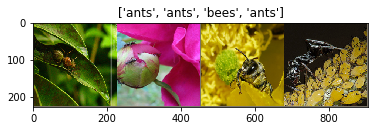

In [64]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])